<a href="https://colab.research.google.com/github/deep1003/deep1003/blob/master/%EC%9D%B8%EB%AC%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0_BERT%ED%99%9C%EC%9A%A9_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT을 통한 딥러닝 분류 학습

사용 알고리즘:  BERT Fine-Tuning Tutorial with PyTorch
-> https://mccormickml.com/2019/07/22/BERT-fine-tuning

사용 데이터: Naver sentiment movie corpus v1.0
https://github.com/e9t/nsmc.git

* 본 내용은 https://github.com/deepseasw/bert-naver-movie-review 를 토대로 수정하였습니다. deepseasw님께 감사 드립니다.


## 환경 설정

**단축키**

In [28]:
# Colab 단축키
# Ctrl + S (저장)
# Ctrl + Enter (셀하나 실행)
# Ctrl + Shift + Enter (선택한 코드만 실행)
# Ctrl + F9 (전체실행)
# Ctrl + F8 (현재 셀 포함 이전 전체 실행)
# Ctrl + F10 (현재 셀 포함 이후 전체 실행)

**구글 드라이브 연결하기**

In [29]:
# Google Drive에 연결
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


**리소스 확인하기**


In [30]:
# Python version
!python --version

#OS Platform
!cat /etc/issue.net

#CPU
!head /proc/cpuinfo

#GPU
!head -n 3 /proc/version

#Memory
!free -h

#Disk
!free -h --si

#Tensorflow version
import tensorflow as tf
print(tf.__version__)

#GPU Monitoring
## 12시간 동안만 무료로 사용
!nvidia-smi


Python 3.10.12
Ubuntu 22.04.3 LTS
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.184
cache size	: 39424 KB
physical id	: 0
Linux version 6.1.85+ (builder@faf02fc191fd) (Chromium OS 16.0_pre484197_p20230405-r10 clang version 16.0.0 (/var/tmp/portage/sys-devel/llvm-16.0_pre484197_p20230405-r10/work/llvm-16.0_pre484197_p20230405/clang 2916b99182752b1aece8cc4479d8d6a20b5e02da), LLD 16.0.0) #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
               total        used        free      shared  buff/cache   available
Mem:            52Gi       3.0Gi        39Gi        16Mi        10Gi        49Gi
Swap:             0B          0B          0B
               total        used        free      shared  buff/cache   available
Mem:             54G        3.0G         40G         16M         10G         50G
Swap:             0B          0B          0B
2.17.0
Sun Oct 13 07:10:12 202

In [31]:
#@title 환경설정

# 이 셀은 필요한 라이브러리를 설치하고, 모델 학습을 위한 환경을 구성하는 코드입니다.

# Hugging Face의 트랜스포머 모델 설치
!pip install transformers

import sys

from IPython.display import clear_output
# 출력 지우기 (환경 설정 후 깔끔한 출력을 위해)
clear_output(wait=True)

## 관련 라이브러리 설치
import tensorflow as tf  # TensorFlow: 딥러닝 프레임워크
import torch  # PyTorch: 딥러닝 프레임워크

# TensorDataset, DataLoader 등: PyTorch에서 데이터 로딩 및 샘플링
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# BERT 모델과 관련된 모듈 임포트
from transformers import BertTokenizer  # BERT 토크나이저 (텍스트를 토큰으로 변환)
from transformers import BertForSequenceClassification, AdamW, BertConfig  # BERT 분류 모델 및 옵티마이저
from transformers import get_linear_schedule_with_warmup  # 학습 스케줄 조절

import keras  # Keras: 딥러닝 라이브러리
# 패딩 함수: 시퀀스 길이를 동일하게 맞춤
from keras.utils import pad_sequences

# 학습 데이터셋을 나누기 위한 함수
from sklearn.model_selection import train_test_split

import pandas as pd  # 데이터 처리 라이브러리
import numpy as np  # 수치 연산을 위한 라이브러리
import random  # 랜덤 연산에 사용
import time  # 시간 측정 관련
import datetime  # 날짜 및 시간 처리

# 출력 정리 (라이브러리 설치 후 필요 없는 출력 지우기)
clear_output()

# Python, TensorFlow, Keras 버전 출력
print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)


Python version :  3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
TensorFlow version :  2.17.0
Keras version :  3.4.1


## 데이터 불러오기

In [32]:
#@title 데이터 불러오기 - 조중동/한경 기사 데이터

# 이 셀은 Google Drive에서 특정 파일을 다운로드하고, 이를 pandas DataFrame으로 변환하는 코드입니다.

# 파일 ID와 저장할 파일 이름 지정
파일ID = '1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F'  #@param {type: "string"}
파일저장이름 = 'rawdata.tsv'  #@param {type: "string"}

# 문서 ID로 Google Drive 파일을 실제로 불러오는 방법
## 조중동한경_정치만_각각_20220510-20230523 : https://drive.google.com/file/d/1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F/

# 파일을 wget을 이용해 다운로드 (Google Drive에서 다운로드 링크 구성)
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt

# 파일 다운로드 확인 메시지 출력
print(파일저장이름+"을 정상적으로 가져왔습니다.")

# pandas 라이브러리 임포트
import pandas as pd

# 다운로드한 파일을 pandas DataFrame으로 전환하고, 결측치가 있는 행 제거
df = pd.read_csv(파일저장이름, sep='\t')
df = df.dropna(axis=0)

# 데이터프레임 출력 (간략화된 데이터 확인을 위해)
df.head()


--2024-10-13 07:10:57--  https://docs.google.com/uc?export=download&confirm=&id=1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F
Resolving docs.google.com (docs.google.com)... 64.233.170.101, 64.233.170.138, 64.233.170.102, ...
Connecting to docs.google.com (docs.google.com)|64.233.170.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F&export=download [following]
--2024-10-13 07:10:57--  https://drive.usercontent.google.com/download?id=1Md8XHJADQWzO1mcl0ZnOm5ijp_cL8G4F&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7737408 (7.4M) [application/octet-stream]
Saving to: ‘rawdata.tsv’

rawdata.tsv         100%[===================>]   7.38M  --.-KB/s 

,label,text
0,경향신문,이낙연 “미국도 할 말 하는 동맹 원할 것 한국 정치 길 잃은 상태”
1,경향신문,"윤재옥 “공직자윤리법, 국회의원만이라도 빠르게 가상자산 신고할 수 있도록 수정안 낼 것”"
2,경향신문,이정미 “노무현 정신 기준에서 정치권 스스로 돌아봐야”
3,경향신문,"민주당, 성추행 고소당한 부천시의원 조사 착수"
4,경향신문,"민주당, 박민식 부적격 기류 인사청문보고서 채택 불발되나"


In [33]:
#@title 데이터 선택하기

데이터량 = "81253"  #@param ['100', '1000', '5000','10000', '50000', '81253']
데이터량 = int(데이터량)

df = df.iloc[:데이터량]
print(df)

print(df["label"].groupby([df["label"]]).count())

      label                                               text
0      경향신문             이낙연 “미국도 할 말 하는 동맹 원할 것 한국 정치 길 잃은 상태”
1      경향신문  윤재옥 “공직자윤리법, 국회의원만이라도 빠르게 가상자산 신고할 수 있도록 수정안 낼 것”
2      경향신문                     이정미 “노무현 정신 기준에서 정치권 스스로 돌아봐야”
3      경향신문                          민주당, 성추행 고소당한 부천시의원 조사 착수
4      경향신문                   민주당, 박민식 부적격 기류  인사청문보고서 채택 불발되나
...     ...                                                ...
81248  동아일보                            국정원장 김규현 내정 북미라인 외교-안보통
81249  동아일보                    한동훈 “국민 보시기 불편 송구하다” 자녀 의혹 첫 사과
81250  동아일보             윤석열 대통령, 공식 임기 시작 0시 용산벙커에서 합참 보고 첫 업무
81251  동아일보                                  [사설]윤석열 대통령에게 바란다
81252  동아일보                [사설]한동훈, 딸 재산 의혹 국민 눈높이에서 겸허하게 해명하라

[81253 rows x 2 columns]
label
경향신문    18534
동아일보    14910
조선일보    16401
중앙일보    20000
한겨레     11408
Name: label, dtype: int64


In [34]:
## 텍스트로 되어 있는 라벨을 숫자로 변환

# 이 셀은 텍스트로 되어 있는 기사 라벨을 숫자로 변환하는 작업을 수행합니다.

# '조선일보', '중앙일보', '동아일보'는 0으로, '한겨레', '경향신문'은 1로 라벨링
df.loc[df.label=='조선일보', 'label']='0'
df.loc[df.label=='중앙일보', 'label']='0'
df.loc[df.label=='동아일보', 'label']='0'
df.loc[df.label=='한겨레', 'label']='1'
df.loc[df.label=='경향신문', 'label']='1'
# 추가적인 라벨링 작업을 위해 주석 처리된 예시
# df.loc[df.label=='분류추가', 'label']='2'

## 라벨 값을 텍스트에서 숫자로 변환
df['label'] = df['label'].apply(pd.to_numeric)  # 숫자로 변환

# 변환된 데이터 확인
print(df.head())  # 데이터의 상위 5개 출력


   label                                               text
0      1             이낙연 “미국도 할 말 하는 동맹 원할 것 한국 정치 길 잃은 상태”
1      1  윤재옥 “공직자윤리법, 국회의원만이라도 빠르게 가상자산 신고할 수 있도록 수정안 낼 것”
2      1                     이정미 “노무현 정신 기준에서 정치권 스스로 돌아봐야”
3      1                          민주당, 성추행 고소당한 부천시의원 조사 착수
4      1                   민주당, 박민식 부적격 기류  인사청문보고서 채택 불발되나


In [35]:
#@title 훈련 데이터 비율 선택하기 (90%)

# 이 셀은 데이터를 훈련용과 테스트용으로 분리하고, 전처리 과정을 수행합니다.

훈련데이터비율 = 0.9  #@param ['0.9', '0.8', '0.7', '0.6']

## 훈련데이터와 테스트데이터로 분리
# 설정된 비율만큼 훈련 데이터로 샘플링, 나머지는 테스트 데이터로 사용
train = df.sample(frac=훈련데이터비율, random_state=200)
test = df.drop(train.index)

# 훈련 데이터 전처리
train.drop_duplicates(subset=['text'], inplace=True)  # 'text' 열에서 중복된 데이터 제거
train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")  # 한글 이외의 문자는 제거
train['text'].replace('', np.nan, inplace=True)  # 빈 문자열을 Null 값으로 변환
train = train.dropna(how='any')  # Null 값이 있는 행 제거
print('전처리 후 훈련용 샘플의 개수 :', len(train))

# 테스트 데이터 전처리
test.drop_duplicates(subset=['text'], inplace=True)  # 'text' 열에서 중복된 데이터 제거
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")  # 한글 이외의 문자는 제거
test['text'].replace('', np.nan, inplace=True)  # 빈 문자열을 Null 값으로 변환
test = test.dropna(how='any')  # Null 값이 있는 행 제거
print('전처리 후 테스트용 샘플의 개수 :', len(test))


전처리 후 훈련용 샘플의 개수 : 72782
전처리 후 테스트용 샘플의 개수 : 8117


<ipython-input-35-098ac3e18f84>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['text'].replace('', np.nan, inplace=True)  # 빈 문자열을 Null 값으로 변환
<ipython-input-35-098ac3e18f84>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

## 데이터 전처리 with bert

In [36]:
#@title 학습 데이터 처리 - BERT형식으로 변환

# 이 셀은 훈련 데이터를 BERT 모델의 입력 형식으로 변환하는 과정을 처리합니다.

# 리뷰 문장 추출 (훈련 데이터의 'text' 열에서 문장만 추출)
sentences = train['text']
print('')
print('##### 원본 데이터 #####')
print(sentences[:10])  # 원본 데이터 상위 10개 출력

# BERT의 입력 형식에 맞게 문장을 변환
# BERT 입력 형식: 문장의 시작에 [CLS], 끝에 [SEP] 추가
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
print('')
print('##### Bert 형식으로 변환 #####')
print(sentences[:10])  # 변환된 데이터 상위 10개 출력

# 라벨 추출 (훈련 데이터의 라벨만 추출)
labels = train['label'].values

print('')
print('##### 라벨 추출 #####')
print(labels)  # 라벨 값 출력



##### 원본 데이터 #####
55262            윤, 취임 1주년 날에도 ‘전 정권’ 탓 “잘못 바로잡아온 시간”
5367                   황운하, 김기현 향해 “윤 대통령의 꼬리 잘치는 푸들”
67660         한동훈 “돈봉투 수사가 정치 탄압? 승부조작 수사하면 스포츠 탄압이냐”
77751              고민정 “文전용기 민간인 안타” 박민영 “김영철 탄 사진은?”
61333              신재생에너지 뜯어본다는 감사원, 작년 “문제없다” 결론 바꿀까
35862               태영호 김재원 버티기에 與 징계수위 고민, 최고회의 또 취소
12447    통일부 5년 만에 감소 ‘담대한 구상’ ‘북한인권 증진’ 힘싣기[2023예산안]
699                한 일 재무장관 회의도 가동 채비 통상 갈등 해소 물꼬 트이나
74905                 “검찰 두려워 할 사람은 범죄자뿐” 한동훈 어록집 나온다
55892           “송영길 있어야 할 곳, 프랑스 아닌 국민 앞” 민주당, 귀국 촉구
Name: text, dtype: object

##### Bert 형식으로 변환 #####
['[CLS] 윤, 취임 1주년 날에도 ‘전 정권’ 탓 “잘못 바로잡아온 시간” [SEP]', '[CLS] 황운하, 김기현 향해 “윤 대통령의 꼬리 잘치는 푸들” [SEP]', '[CLS] 한동훈 “돈봉투 수사가 정치 탄압? 승부조작 수사하면 스포츠 탄압이냐” [SEP]', '[CLS] 고민정 “文전용기 민간인 안타” 박민영 “김영철 탄 사진은?” [SEP]', '[CLS] 신재생에너지 뜯어본다는 감사원, 작년 “문제없다” 결론 바꿀까 [SEP]', '[CLS] 태영호 김재원 버티기에 與 징계수위 고민, 최고회의 또 취소 [SEP]', '[CLS] 통일부 5년 만에 감소 ‘담대한 구상’ ‘북한인권 증진’ 힘싣기[2023예산안] [SEP]', '[CLS] 한 일 재무장관 회의도 가동 채비

![대체 텍스트](https://mino-park7.github.io/images/2019/02/bert-input-representation.png)

BERT의 입력은 위의 그림과 같은 형식입니다. Classification을 뜻하는 [CLS] 심볼이 제일 앞에 삽입됩니다. 파인튜닝시 출력에서 이 위치의 값을 사용하여 분류를 합니다. [SEP]은 Separation을 가리키는데, 두 문장을 구분하는 역할을 합니다. 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣습니다.
<br>
<br>

In [37]:
#@title 학습 데이터 처리 - BERT로 토큰화하기

# 이 셀은 BERT 모델을 사용해 훈련 데이터를 토큰화하는 과정을 처리합니다.

# 사용할 BERT 모델 선택 (다국어 모델인 'bert-base-multilingual-cased'를 기본으로 선택)
bert모델 = "bert-base-multilingual-cased"  #@param ['bert-base-multilingual-cased', 'bert-large-cased', 'bert-base-chinese']

# BERT의 다양한 모델 URL 예시 (주석 처리)
# "bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
# "bert-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
# "bert-base-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
# "bert-large-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
# "bert-base-multilingual-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
# "bert-base-multilingual-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
# "bert-base-chinese": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",

# 선택한 BERT 모델의 토크나이저를 사용하여 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 첫 번째 문장의 원본과 토큰화된 결과를 출력
print('')
print('##### 원본 문장 #####')
print(sentences[0])

print('')
print('##### 토큰화된 문장 #####')
print(tokenized_texts[0])



##### 원본 문장 #####
[CLS] 윤, 취임 1주년 날에도 ‘전 정권’ 탓 “잘못 바로잡아온 시간” [SEP]

##### 토큰화된 문장 #####
['[CLS]', '윤', ',', '취임', '1', '##주', '##년', '날', '##에도', '[UNK]', '전', '정', '##권', '[UNK]', '탓', '[UNK]', '잘', '##못', '바로', '##잡', '##아', '##온', '시', '##간', '[UNK]', '[SEP]']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT는 형태소분석으로 토큰을 분리하지 않습니다. WordPiece라는 통계적인 방식을 사용합니다. 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋습니다.

위의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시입니다. 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용합니다. 그래서 한글도 처리가 가능합니다.
<br>
<br>

문장의 최대 길이 : 180
문장의 평균 길이 : 45.901060701821876


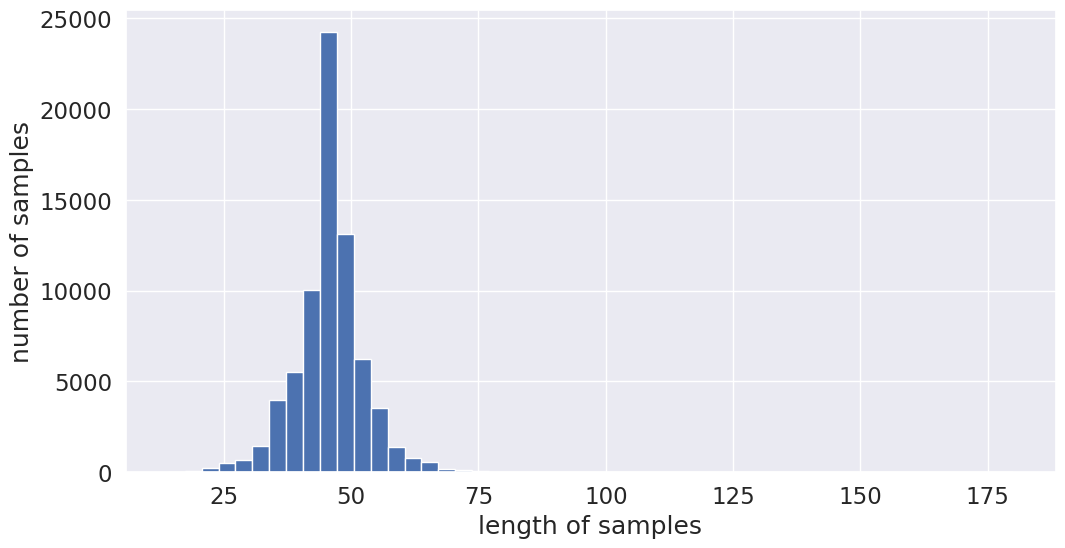

전체 샘플 중 길이가 64 이하인 샘플의 비율: 98.77442224725894


In [38]:
#@title 전처리를 위한 문장 길이 조회

## 전처리를 위한 기본 텍스트 정보를 탐색합니다.

최대길이 = "64"  #@param ['32', '64', '128', '256']
최대길이 = int(최대길이)

print('문장의 최대 길이 :',max(len(l) for l in sentences))
## 문장의 최대 길이는 가장 긴 문장의 길이를 의미합니다.

print('문장의 평균 길이 :',sum(map(len, sentences))/len(sentences))
## 문장의 평균 길이는 문장 길이의 평균값을 의미합니다.

import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 문장 길이 전체 그래프를 살펴보면, 문장의 전체 분포를 볼 수 있습니다.
## 대다수의 문장이 50자 이하인 것을 알 수 있습니다.


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


max_len = 최대길이
below_threshold_len(max_len, sentences)

## max_leb(문장 최대 길이)가 128일때 선택되는 전체 데이터량을 의미합니다.
## 현재값은 95.92로 대략 6%를 제외한 모든 데이터가 선택된 것을 확인할 수 있습니다.

In [39]:
#@title 토큰 인덱스 변환, 패딩 및 어텐션 마스크 세팅

# 이 셀은 토큰을 숫자 인덱스로 변환하고, 패딩 및 어텐션 마스크를 설정하는 과정을 처리합니다.

# 입력 토큰의 최대 시퀀스 길이 설정
MAX_LEN = 최대길이

## 입력 문장의 최대 길이를 지정해 줍니다.
## MAX_LEN 값을 너무 크게 설정하면 처리 시간이 길어지지만, 정확도가 올라갈 수 있습니다.
## 반대로 MAX_LEN 값을 작게 설정하면 처리 시간은 짧아지지만, 정확도가 낮아질 수 있습니다.
## MAX_LEN은 적절한 값을 선택하는 것이 중요합니다.

# 토큰을 숫자 인덱스로 변환 (BERT 모델에 입력하기 위해 토큰을 숫자 ID로 변환)
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분은 0으로 패딩
# 패딩을 통해 짧은 문장을 고정된 길이로 맞추어 BERT 모델에 입력
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 첫 번째 문장의 인덱스 값 출력
print(input_ids[0])

# 어텐션 마스크 초기화 (어텐션을 적용할 부분을 표시하기 위한 마스크)
attention_masks = []

# 패딩이 아닌 부분에는 1, 패딩된 부분에는 0을 설정
# BERT 모델은 어텐션 마스크를 통해 패딩 부분을 무시하고 효율적으로 처리함
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# 첫 번째 문장의 어텐션 마스크 출력
print(attention_masks[0])


[   101   9627    117  71963    122  16323  10954   8985  35979    100
   9665   9670  25347    100   9851    100   9654 118940  71433 119199
  16985  37093   9485  18784    100    102      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [40]:
#@title 훈련데이터와 검증 데이터 분리 및 배치 세팅

# 이 셀은 훈련 데이터를 검증 데이터와 분리하고, 배치 크기를 설정하여 DataLoader를 생성하는 과정입니다.

검증데이터비율 = "0.2"  #@param ['0.1', '0.2', '0.3']

배치크기 = "64"  #@param ['8', '16', '32', '64', '128', '256']
배치크기 = int(배치크기)  # 배치 크기를 정수로 변환

# 훈련셋과 검증셋으로 분리 (훈련 데이터를 9:1 비율로 분리)
validation_size = 검증데이터비율  # 검증 데이터 비율 설정
random_state = 1  # 랜덤 시작값 설정 (재현 가능한 결과를 위해 고정)

# 훈련셋과 검증셋으로 입력, 라벨, 어텐션 마스크를 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=random_state, test_size=0.1
)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=random_state, test_size=0.1
)

# 데이터를 PyTorch 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

# 훈련 데이터 샘플 출력
print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])

# 검증 데이터 샘플 출력
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])

# 배치 사이즈 설정
batch_size = 배치크기

# PyTorch의 DataLoader로 훈련 및 검증 데이터를 배치 단위로 묶음
# 학습시 배치 사이즈만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)  # 훈련 데이터는 랜덤으로 샘플링
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)  # 검증 데이터는 순차적으로 샘플링
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


##### 훈련 텍스트의 bert embedding값 #####
tensor([   101,    112,   9297,  13764,   9901,  18778,    112,   9987, 118792,
         10459,   8909,  36553,  10459, 119471,   9330,  30842,  18623,    107,
          9580, 118762,  83491,  19855,  14279,   9405, 119362,    107,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
##### 훈련 텍스트의 label 값 #####
tensor(0)
##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
##### 검증 텍스트의 bert embe

In [41]:
#@title 테스트 데이터 처리(훈련데이터와 동일)

# 이 셀은 테스트 데이터를 훈련 데이터와 동일한 방식으로 처리하여 BERT 모델에 입력할 준비를 합니다.

# 리뷰 문장 추출 (테스트 데이터의 'text' 열에서 문장만 추출)
sentences = test['text']

# BERT의 입력 형식에 맞게 문장을 변환 (문장의 앞뒤에 [CLS]와 [SEP] 추가)
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출 (테스트 데이터의 'label' 열에서 라벨만 추출)
labels = test['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환 (BERT 모델에 입력할 수 있는 숫자 형태로 변환)
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 최대 길이(MAX_LEN)로 맞추고, 부족한 부분은 0으로 패딩 처리
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화 (패딩된 부분을 무시하도록 마스크 설정)
attention_masks = []

# 패딩이 아닌 부분에는 1, 패딩된 부분에는 0을 설정하여 어텐션 마스크 생성
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환 (BERT 모델에 입력할 수 있도록 변환)
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 테스트 데이터를 파이토치의 DataLoader로 묶어 배치 단위로 처리
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)  # 랜덤으로 샘플링
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)


## 모델 세팅

In [42]:
#@title GPU 세팅

# 이 셀은 GPU가 사용 가능한지 확인하고, GPU가 있을 경우 해당 디바이스를 설정합니다.
# 만약 GPU가 없으면 CPU를 사용하도록 설정됩니다.
# GPU 설정은 더 빠른 학습을 가능하게 합니다.

## 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 확인
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))  # GPU가 발견된 경우 출력
else:
    raise SystemError('GPU device not found')  # GPU가 없으면 에러 발생

# PyTorch에서 사용할 디바이스 설정
if torch.cuda.is_available():  # GPU 사용 가능 여부 확인
    device = torch.device("cuda")  # GPU를 사용하도록 설정
    print('There are %d GPU(s) available.' % torch.cuda.device_count())  # 사용 가능한 GPU 개수 출력
    print('We will use the GPU:', torch.cuda.get_device_name(0))  # 첫 번째 GPU 이름 출력
else:
    device = torch.device("cpu")  # GPU가 없으면 CPU로 설정
    print('No GPU available, using the CPU instead.')  # CPU 사용 경고 출력


Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [43]:
#@title 딥러닝 모델 세팅

# 이 셀은 분류를 위한 BERT 모델을 설정하고, 옵티마이저와 학습 스케줄러를 정의하는 과정입니다.

# 분류 개수와 에폭 수 설정
분류개수 = "2"  #@param ['2', '3', '4', '5']
분류개수 = int(분류개수)  # 분류 개수를 정수로 변환

# 훈련데이터를 통해서 학습을 몇번을 시킬지 결정: 3번
epochs수 = "3"  #@param ['2', '3', '4', '5']
epochs수 = int(epochs수)  # 에폭 수를 정수로 변환

# 분류를 위한 BERT 모델 생성
# BERT 모델을 사용하여 이진 분류(긍정-부정) 혹은 다중 분류 설정 (분류 개수는 num_labels로 설정)
model = BertForSequenceClassification.from_pretrained(bert모델, num_labels=분류개수)
model.cuda()  # GPU 사용

# 옵티마이저 설정 (AdamW 옵티마이저 사용)
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # 학습률 (learning rate)
                  eps=1e-8  # 작은 값으로 0으로 나누는 오류 방지
                  )

# 에폭 수 설정
epochs = epochs수

# 총 훈련 스텝 수 계산 : 배치 반복 횟수 * 에폭 수
total_steps = len(train_dataloader) * epochs

# 학습률을 점진적으로 줄이는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # 초기 몇 스텝 동안 학습률을 0에서 서서히 증가
                                            num_training_steps=total_steps)  # 전체 학습 스텝 수


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
#@title 딥러닝 모델 간략 보기

# 이 셀은 BERT 모델의 각 레이어와 파라미터 정보를 간략하게 출력합니다.

# 모델의 모든 파라미터를 리스트로 가져옴
params = list(model.named_parameters())

# 모델에 있는 파라미터들의 개수를 출력
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# BERT의 임베딩 레이어 파라미터 출력 (처음 5개의 파라미터)
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# BERT의 첫 번째 트랜스포머 레이어 파라미터 출력 (6번째부터 21번째까지)
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# BERT의 출력 레이어 파라미터 출력 (마지막 4개의 파라미터)
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 모델 학습

In [45]:
#@title 딥러닝 학습

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 시간을 hh:mm:ss 형식으로 변환
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 랜덤 시드 고정 (재현성을 위해)
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 훈련과 검증 과정의 정보를 저장할 리스트
training_stats = []

# 총 학습 시간을 측정
total_t0 = time.time()

# 에폭 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 에폭 시작 시간
    t0 = time.time()

    # 전체 훈련 손실값 초기화
    total_train_loss = 0

    # 모델을 훈련 모드로 설정
    model.train()

    # 배치 반복
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치 데이터를 GPU로 이동
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 초기화
        model.zero_grad()

        # Forward 수행 (모델 적용)
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # 손실값 계산
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        # Backward 수행 (그래디언트 계산)
        loss.backward()

        # 그래디언트 클리핑 (그래디언트 폭발 방지)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 옵티마이저로 가중치 업데이트
        optimizer.step()

        # 학습률 스케줄러 업데이트
        scheduler.step()

    # 평균 훈련 손실값 계산
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 에폭 당 훈련 시간 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    # 검증 시작 시간
    t0 = time.time()

    # 모델을 평가 모드로 설정
    model.eval()

    # 변수 초기화
    total_eval_accuracy = 0
    total_eval_loss = 0

    # 배치 반복 (검증 데이터)
    for batch in validation_dataloader:
        # 배치 데이터를 GPU로 이동
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 계산 안 함 (평가이므로)
        with torch.no_grad():
            # Forward 수행 (모델 적용)
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # 검증 손실값 계산
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # 로짓을 CPU로 이동하여 정확도 계산
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # 평균 검증 정확도 계산
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 평균 검증 손실값 계산
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # 검증 시간 측정
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 훈련 및 검증 결과 저장
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))



======== Epoch 1 / 3 ========
Training...
  Batch   500  of  1,024.    Elapsed: 0:02:26.
  Batch 1,000  of  1,024.    Elapsed: 0:04:52.

  Average training loss: 0.38
  Training epoch took: 0:04:59

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.34
  Validation took: 0:00:11

======== Epoch 2 / 3 ========
Training...
  Batch   500  of  1,024.    Elapsed: 0:02:26.
  Batch 1,000  of  1,024.    Elapsed: 0:04:52.

  Average training loss: 0.31
  Training epoch took: 0:04:58

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.32
  Validation took: 0:00:11

======== Epoch 3 / 3 ========
Training...
  Batch   500  of  1,024.    Elapsed: 0:02:26.
  Batch 1,000  of  1,024.    Elapsed: 0:04:51.

  Average training loss: 0.27
  Training epoch took: 0:04:58

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.32
  Validation took: 0:00:11

Training complete!
Total training took 0:15:30 (h:mm:ss)


       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           0.384376     0.338341       0.833199       0:04:59         0:00:11
2           0.314635     0.322841       0.841659       0:04:58         0:00:11
3           0.274847     0.321536       0.847964       0:04:58         0:00:11


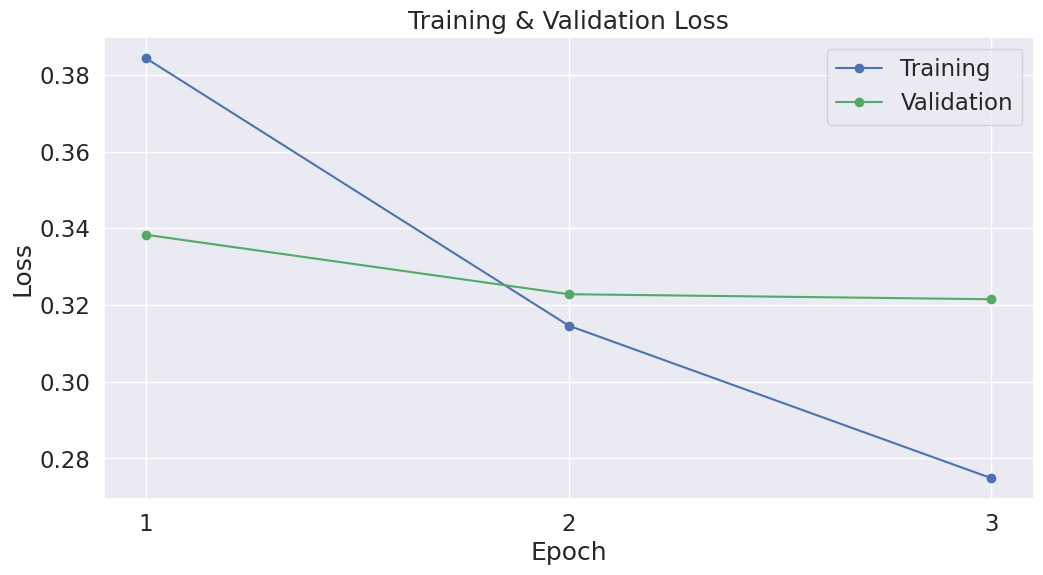

In [46]:
#@title 딥러닝 학습 간단 보기

import pandas as pd

# 훈련 통계 데이터를 DataFrame으로 생성
df_stats = pd.DataFrame(data=training_stats)

# 'epoch'를 행 인덱스로 설정
df_stats = df_stats.set_index('epoch')

# 통계 테이블 출력
print(df_stats.to_string())

# 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# 시각화 스타일 설정 (seaborn 사용)
sns.set(style='darkgrid')

# 그래프 크기와 폰트 크기 설정
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# 학습 및 검증 손실값을 그래프로 시각화
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# 그래프 제목과 라벨 설정
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 에폭 수에 따라 x축 레이블 설정
plt.xticks([i for i in range(1, epochs수+1)])

# 그래프 출력
plt.show()


  Batch   100  of    127.    Elapsed: 0:00:10.

##### 테스트 모델을 통한 모델 정확도 #####
Accuracy: 0.84
Test took: 0:00:13

              precision    recall  f1-score   support

        bosu       0.87      0.87      0.87      5082
       jinbo       0.79      0.78      0.78      3035

    accuracy                           0.84      8117
   macro avg       0.83      0.83      0.83      8117
weighted avg       0.84      0.84      0.84      8117



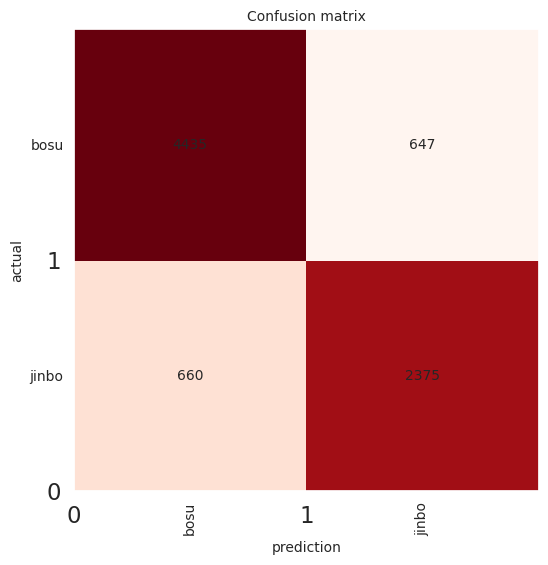

In [47]:
#@title 딥러닝 학습 평가하기

# 라벨링 설정 (예: '보수', '진보')
라벨링 = ['bosu', 'jinbo']  #@param

# 시작 시간 설정
t0 = time.time()

# 평가 모드로 변경 (모델을 평가 상태로 설정)
model.eval()

# 변수 초기화
predictions, true_labels, predictionsfin = [], [], []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps = 0

# 테스트 데이터셋을 배치 단위로 반복하여 처리
for step, batch in enumerate(test_dataloader):
    # 진행 상태 출력 (100 배치마다 경과 시간 출력)
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치 데이터를 GPU로 이동
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (모델 예측)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로짓(logits) 구하기
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 예측 값과 실제 라벨 저장
    predictions.append(logits)
    true_labels.append(label_ids)

    # 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

# 모델 평가 결과 출력
print("\n##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

# 모델 상세 평가
from sklearn.metrics import classification_report

# 각 배치에 대한 예측 라벨 및 실제 라벨을 처리
rounded_labels_set = []
rounded_predictions_set = []
for i in range(len(true_labels)):
    rounded_labels = np.argmax(predictions[i], axis=1).flatten()
    rounded_labels_set.extend(rounded_labels)
    rounded_predictions = true_labels[i].flatten()
    rounded_predictions_set.extend(rounded_predictions)

# 분류 리포트 출력 (정밀도, 재현율, F1 점수)
labels = 라벨링
print("\n" + classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))

# 혼돈 행렬 (Confusion Matrix) 생성 및 시각화
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 혼돈 행렬 계산
cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

# 혼돈 행렬을 시각화하는 함수 정의
def plot_confusion_matrix(ax, matrix, labels, title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)
    ax.tick_params(which='major', labelbottom='off', labelleft='off')
    ax.tick_params(which='minor', width=0)
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)
    plt.show()

# 혼돈 행렬 시각화
if __name__ == '__main__':
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(ax, cm, 라벨링, fontsize=10)


## 예측 모델 실전 테스트#

In [48]:
#@title 딥러닝 모델로 예측하기

테스트용텍스트 = '윤이 열창한 노래, 바이든이 죽은 장남과 즐겨 불렀던 곡이었다'  #@param {type: "string"}

# 입력 데이터 변환 함수
def convert_input_data(sentences):
    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0)
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 PyTorch 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 예측 함수
def test_sentences(sentences):
    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 데이터를 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU로 이동
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (예측)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로짓(logits) 계산
    logits = outputs[0]

    # CPU로 이동하여 로짓 값 반환
    logits = logits.detach().cpu().numpy()

    return logits

# 테스트용 문장 예측
logits = test_sentences([테스트용텍스트])

# 결과 출력
print("Logits:", logits)
print("Predicted class:", np.argmax(logits))


Logits: [[ 1.2761788 -1.1170678]]
Predicted class: 0


In [49]:
#@title 딥러닝 모델로 예측하기

테스트용텍스트 = '미국 기자 “도청 재발방지 약속 받았나?” 윤 “시간을 두고…”'  #@param {type: "string"}

# 입력 데이터 변환 함수
def convert_input_data(sentences):
    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0)
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 PyTorch 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 예측 함수
def test_sentences(sentences):
    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 데이터를 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU로 이동
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (예측)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로짓(logits) 계산
    logits = outputs[0]

    # CPU로 이동하여 로짓 값 반환
    logits = logits.detach().cpu().numpy()

    return logits

# 테스트용 문장 예측
logits = test_sentences([테스트용텍스트])

# 결과 출력
print("Logits:", logits)
print("Predicted class:", np.argmax(logits))


Logits: [[-1.8437968  2.220135 ]]
Predicted class: 1


In [50]:
#@title 딥러닝 모델로 예측하기

테스트용텍스트 = '워싱턴 선언 나온 날... 文 “판문점 선언은 평화 이정표, 한반도정세 악화”'  #@param {type: "string"}

# 입력 데이터 변환 함수
def convert_input_data(sentences):
    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0)
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 PyTorch 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 예측 함수
def test_sentences(sentences):
    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 데이터를 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU로 이동
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (예측)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로짓(logits) 계산
    logits = outputs[0]

    # CPU로 이동하여 로짓 값 반환
    logits = logits.detach().cpu().numpy()

    return logits

# 테스트용 문장 예측
logits = test_sentences([테스트용텍스트])

# 결과 출력
print("Logits:", logits)
print("Predicted class:", np.argmax(logits))


Logits: [[ 2.451244  -2.9605143]]
Predicted class: 0


In [51]:
#@title 딥러닝 모델로 예측하기

테스트용텍스트 = '간호법 국회 통과…국힘은 ‘간호사 출신’ 최연숙만 찬성'  #@param {type: "string"}

# 입력 데이터 변환 함수
def convert_input_data(sentences):
    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0)
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 PyTorch 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 예측 함수
def test_sentences(sentences):
    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 데이터를 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU로 이동
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (예측)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로짓(logits) 계산
    logits = outputs[0]

    # CPU로 이동하여 로짓 값 반환
    logits = logits.detach().cpu().numpy()

    return logits

# 테스트용 문장 예측
logits = test_sentences([테스트용텍스트])

# 결과 출력
print("Logits:", logits)
print("Predicted class:", np.argmax(logits))


Logits: [[-0.2443462   0.48336732]]
Predicted class: 1


## 딥러닝 모델의 저장 & 불러오기

In [73]:
#@title 모델 저장하기 (1)

import os

# 모델 저장 경로 설정
save_directory = "/content/drive/MyDrive/Colab Notebooks/Models/"

# 디렉토리가 존재하지 않으면 생성
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

print("Saving model to %s" % save_directory)


# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"모델과 토크나이저가 {save_directory}에 저장되었습니다.")

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(save_directory, 'training_args.bin'))


# # 모델 저장 함수
# def save_model(model, tokenizer, save_directory):
#     # 모델 저장
#     model.save_pretrained(save_directory)
#     # 토크나이저 저장
#     tokenizer.save_pretrained(save_directory)
#     print(f"모델과 토크나이저가 {save_directory}에 저장되었습니다.")

# # 훈련 후 모델 저장
# save_model(model, tokenizer, save_directory)


Saving model to /content/drive/MyDrive/Colab Notebooks/Models/
모델과 토크나이저가 /content/drive/MyDrive/Colab Notebooks/Models/에 저장되었습니다.


In [80]:
!ls -l --block-size=K ./drive/MyDrive/Colab\ Notebooks/Models/

total 695747K
-rw------- 1 root root      1K Oct 13 08:33 config.json
-rw------- 1 root root 694769K Oct 13 08:33 model.safetensors
-rw------- 1 root root      3K Oct 13 08:03 pytorch_model.bin
-rw------- 1 root root      1K Oct 13 08:33 special_tokens_map.json
-rw------- 1 root root      2K Oct 13 08:33 tokenizer_config.json
-rw------- 1 root root    973K Oct 13 08:33 vocab.txt


In [71]:
# #@title 모델 저장하기 (2)

# # 모델을 로컬 경로에 저장
# model.save_pretrained('.')



# # 저장된 모델 파일을 Google Drive의 지정 경로로 복사
# !mkdir -p "/content/drive/MyDrive/Colab Notebooks/Models"  # 경로가 없을 경우 폴더를 생성
# !cp "/content/pytorch_model.bin" "/content/drive/MyDrive/Colab Notebooks/Models/"
# !cp "/content/config.json" "/content/drive/MyDrive/Colab Notebooks/Models/"


### 딥러닝 모델 불러오기

In [85]:
#@title 데이터 불러오기 - 모델 불러오기 (1)

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 모델 경로
model_directory = "/content/drive/MyDrive/Colab Notebooks/Models/"

# 모델과 토크나이저 불러오기
model = AutoModelForSequenceClassification.from_pretrained(model_directory, use_safetensors=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)

print("모델과 토크나이저가 성공적으로 불러와졌습니다.")

# Copy the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



모델과 토크나이저가 성공적으로 불러와졌습니다.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [60]:
#@title 데이터 불러오기 - 모델 불러오기 (2)

# 문서 ID로 실제 파일 불러오는 법
# pytorch_model.bin 링크 기입
## https://drive.google.com/file/d/1WlA1H9zlXyYFqrW0Yt1MsYKhCoW1ss8t/
파일ID = '1WlA1H9zlXyYFqrW0Yt1MsYKhCoW1ss8t'
파일저장이름 = 'pytorch_model.bin'

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt


# config.json 링크 기입
## https://drive.google.com/file/d/1tus80Qm7dUDK-Mut_kEknxFCYZTWmCMy/
파일ID = '1tus80Qm7dUDK-Mut_kEknxFCYZTWmCMy'
파일저장이름 = 'config.json'

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt


--2024-10-13 07:47:01--  https://docs.google.com/uc?export=download&confirm=&id=1WlA1H9zlXyYFqrW0Yt1MsYKhCoW1ss8t
Resolving docs.google.com (docs.google.com)... 64.233.170.138, 64.233.170.139, 64.233.170.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.170.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1WlA1H9zlXyYFqrW0Yt1MsYKhCoW1ss8t&export=download [following]
--2024-10-13 07:47:02--  https://drive.usercontent.google.com/download?id=1WlA1H9zlXyYFqrW0Yt1MsYKhCoW1ss8t&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2429 (2.4K) [text/html]
Saving to: ‘pytorch_model.bin’

pytorch_model.bin   100%[===================>]   2.37K  --.-KB/s    in 0s    

In [63]:
#@title 불러온 모델을 위한 환경 세팅

# 사용할 BERT 모델 선택 (다국어 모델 사용: 'bert-base-multilingual-cased')
bert모델 = "bert-base-multilingual-cased"  #@param ['bert-base-multilingual-cased', 'bert-large-cased', 'bert-base-chinese']

# Hugging Face의 트랜스포머 모델 설치 (transformers 라이브러리 설치)
!pip install transformers

# 라이브러리 임포트 및 초기 설정
import sys
from IPython.display import clear_output
clear_output(wait=True)  # 설치 완료 후 출력 내용 정리

# 필요한 라이브러리 임포트
import tensorflow as tf  # TensorFlow 라이브러리
import torch  # PyTorch 라이브러리
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Hugging Face에서 제공하는 BERT 관련 모듈 임포트
from transformers import BertTokenizer, BertForSequenceClassification
from keras.utils import pad_sequences  # Keras에서 제공하는 패딩 함수
import numpy as np  # NumPy 라이브러리

## GPU 설정 확인 (에러 발생 시: "런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU"로 변경 필요)

# GPU 디바이스 확인
device_name = tf.test.gpu_device_name()

# GPU 사용 가능 여부 확인
if device_name == '/device:GPU:0':  # GPU가 사용 가능하면 해당 디바이스 이름 출력
    print('Found GPU at: {}'.format(device_name))
else:
    # GPU가 없을 경우 에러 발생
    raise SystemError('GPU device not found')

# PyTorch에서 사용할 디바이스 설정
if torch.cuda.is_available():
    # GPU가 사용 가능한 경우
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())  # 사용 가능한 GPU 개수 출력
    print('We will use the GPU:', torch.cuda.get_device_name(0))  # 첫 번째 GPU 이름 출력
else:
    # GPU가 사용 불가능할 경우 CPU 사용
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

# BERT 토크나이저 로드 (BERT 모델 입력을 위한 토큰화 작업을 수행할 토크나이저 설정)
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)  # 다국어 모델 사용

# 저장된 모델 불러오기 (사전 학습된 BERT 모델 불러옴)
# "." 경로에서 사전 학습된 모델을 불러오며, 분류할 클래스의 개수는 2로 설정
model = BertForSequenceClassification.from_pretrained(".", num_labels=2)
model.cuda()  # 모델을 GPU로 이동 (GPU에서 연산 처리)

# 환경 설정 완료 메시지 출력
clear_output()  # 출력 내용 정리
print('환경 설정이 완료되었습니다.')  # 설정 완료 메시지


환경 설정이 완료되었습니다.


In [64]:
#@title 딥러닝 모델로 예측하기

# 테스트할 텍스트 (사용자가 입력한 문장)
테스트용텍스트 = '윤이 열창한 노래, 바이든이 죽은 장남과 즐겨 불렀던 곡이었다'  #@param {type: "string"}

# 입력 데이터 변환 함수
def convert_input_data(sentences):

    # BERT 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0)
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 PyTorch 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 예측 함수
def test_sentences(sentences):

    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 데이터를 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU로 이동
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (모델을 통해 예측)
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로짓(logits) 계산 (모델의 예측 결과)
    logits = outputs[0]

    # CPU로 이동하여 로짓 값 반환
    logits = logits.detach().cpu().numpy()

    return logits

# 테스트용 문장 예측
logits = test_sentences([테스트용텍스트])

# 결과 출력
print("Logits:", logits)  # 모델의 출력 로짓 값
print("Predicted class:", np.argmax(logits))  # 예측된 클래스 (최대값을 갖는 인덱스)


Logits: [[ 1.2761788 -1.1170678]]
Predicted class: 0


In [65]:
#@title 딥러닝 모델로 예측하기

# 테스트할 텍스트 (사용자가 입력한 문장)
테스트용텍스트 = '간호법 국회 통과…국힘은 ‘간호사 출신’ 최연숙만 찬성'  #@param {type: "string"}

# 입력 데이터 변환 함수
def convert_input_data(sentences):

    # BERT 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이 설정
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0)
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 PyTorch 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 예측 함수
def test_sentences(sentences):

    # 모델을 평가 모드로 설정
    model.eval()

    # 입력 데이터를 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU로 이동
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 평가 중에는 그래디언트 계산을 하지 않음
    with torch.no_grad():
        # Forward 수행 (모델을 통해 예측)
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로짓(logits) 계산 (모델의 예측 결과)
    logits = outputs[0]

    # CPU로 이동하여 로짓 값 반환
    logits = logits.detach().cpu().numpy()

    return logits

# 테스트용 문장 예측
logits = test_sentences([테스트용텍스트])

# 결과 출력
print("Logits:", logits)  # 모델의 출력 로짓 값
print("Predicted class:", np.argmax(logits))  # 예측된 클래스 (최대값을 갖는 인덱스)


Logits: [[-0.2443462   0.48336732]]
Predicted class: 1


## 심화 학습 : 테스트용 데이터 대량 입력하기

In [66]:
#@title 데이터 불러오기 - 테스트 데이터

파일ID = '1DKKis8ChPNDpouzhdye24iQsAr0aBX4F'  #@param {type: "string"}
파일저장이름 = 'rawdata2.tsv'  #@param {type: "string"}

# Google Drive에서 파일 불러오는 코드
## 파일 링크: 조중동한경_정치만_각각_20161101-20161231
## https://drive.google.com/file/d/1DKKis8ChPNDpouzhdye24iQsAr0aBX4F/

# wget 명령을 통해 Google Drive에서 파일을 다운로드
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt

# 파일 다운로드 성공 메시지 출력
print(파일저장이름 + "을 정상적으로 가져왔습니다.")

# pandas 라이브러리 임포트
import pandas as pd

# 다운로드한 파일을 pandas DataFrame으로 전환
df2 = pd.read_csv(파일저장이름, sep='\t')

# 결측치가 있는 행을 제거
df2 = df2.dropna(axis=0)

# DataFrame 출력 (데이터 확인)
df2.head()


--2024-10-13 07:56:40--  https://docs.google.com/uc?export=download&confirm=&id=1DKKis8ChPNDpouzhdye24iQsAr0aBX4F
Resolving docs.google.com (docs.google.com)... 142.251.175.138, 142.251.175.139, 142.251.175.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.175.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1DKKis8ChPNDpouzhdye24iQsAr0aBX4F&export=download [following]
--2024-10-13 07:56:40--  https://drive.usercontent.google.com/download?id=1DKKis8ChPNDpouzhdye24iQsAr0aBX4F&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1294443 (1.2M) [application/octet-stream]
Saving to: ‘rawdata2.tsv’

rawdata2.tsv        100%[===================>]   1.23M  --.-

,label,text
0,경향신문,[경향포토]새해 촛불 밝히는 어린이
1,경향신문,[경향포토]송박영신
2,경향신문,[경향포토]송박영신 축포
3,경향신문,[경향포토]정경유착 퍼포먼스
4,경향신문,[경향포토]송박영신 세월호 진실을 인양하라


In [67]:
#@title 데이터 선택하기

# 사용할 데이터의 양을 설정 (기본값: 14971개)
데이터량 = "14971"  #@param ['100', '1000', '5000', '10000', '14971']
데이터량 = int(데이터량)  # 문자열을 정수로 변환

# 데이터프레임에서 설정된 개수만큼 데이터를 선택
df2 = df2.iloc[:데이터량]

# 선택된 데이터 출력
print(df2)

# 각 라벨별 데이터 개수 출력 (라벨별 그룹화 후 개수 계산)
print(df2["label"].groupby([df2["label"]]).count())


      label                                            text
0      경향신문                             [경향포토]새해 촛불 밝히는 어린이
1      경향신문                                      [경향포토]송박영신
2      경향신문                                   [경향포토]송박영신 축포
3      경향신문                                 [경향포토]정경유착 퍼포먼스
4      경향신문                         [경향포토]송박영신 세월호 진실을 인양하라
...     ...                                             ...
14966  중앙일보                                    [인사] 기획재정부 外
14967  중앙일보                    [취재일기] 이상돈도 안 최순실, 친박은 몰랐다고?
14968  중앙일보  평화 오디세이 2016 참가자 릴레이 기고 <12> 러시아에서 한반도 평화를 꿈꾸다
14969  중앙일보                   [글로벌 아이] 최순실 사태, 국가 시스템을 수술하라
14970  중앙일보                     [인사] SPC그룹 임원 인사 허희수 신임 부사장

[14971 rows x 2 columns]
label
경향신문    5742
동아일보    1951
중앙일보    4584
한겨레     2694
Name: label, dtype: int64


In [68]:
## 텍스트로 되어 있는 라벨을 숫자로 변환

# '조선일보', '중앙일보', '동아일보'는 라벨 0으로 설정
df2.loc[df2.label=='조선일보', 'label'] = '0'
df2.loc[df2.label=='중앙일보', 'label'] = '0'
df2.loc[df2.label=='동아일보', 'label'] = '0'

# '한겨레', '경향신문'은 라벨 1로 설정
df2.loc[df2.label=='한겨레', 'label'] = '1'
df2.loc[df2.label=='경향신문', 'label'] = '1'

# 라벨 값을 텍스트에서 숫자로 변환
df2['label'] = df2['label'].apply(pd.to_numeric)

# 변환된 데이터 확인
print(df2)


       label                                            text
0          1                             [경향포토]새해 촛불 밝히는 어린이
1          1                                      [경향포토]송박영신
2          1                                   [경향포토]송박영신 축포
3          1                                 [경향포토]정경유착 퍼포먼스
4          1                         [경향포토]송박영신 세월호 진실을 인양하라
...      ...                                             ...
14966      0                                    [인사] 기획재정부 外
14967      0                    [취재일기] 이상돈도 안 최순실, 친박은 몰랐다고?
14968      0  평화 오디세이 2016 참가자 릴레이 기고 <12> 러시아에서 한반도 평화를 꿈꾸다
14969      0                   [글로벌 아이] 최순실 사태, 국가 시스템을 수술하라
14970      0                     [인사] SPC그룹 임원 인사 허희수 신임 부사장

[14971 rows x 2 columns]


In [69]:
#@title 테스트용 데이터 전처리

## 전처리를 위한 기본 텍스트 정보를 탐색하고, 데이터 처리 후 BERT 모델에 입력할 준비를 합니다.

# 최대 문장 길이와 배치 크기 설정
최대길이 = "64"  #@param ['32', '64', '128', '256']
최대길이 = int(최대길이)  # 최대 길이를 정수로 변환
배치크기 = "64"  #@param ['8', '16', '32', '64', '128', '256']
배치크기 = int(배치크기)  # 배치 크기를 정수로 변환

# 테스트용 데이터로 df2 사용
test = df2

# 중복된 텍스트 제거
test.drop_duplicates(subset=['text'], inplace=True)

# 한글 외의 문자를 제거 (정규 표현식 수행)
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

# 빈 문자열을 NaN 값으로 변환 후 제거
test['text'].replace('', np.nan, inplace=True)
test = test.dropna(how='any')

# 전처리 후 남은 테스트 데이터 개수 출력
print('전처리 후 테스트용 샘플의 개수 :', len(test))

#@title 테스트 데이터 처리(훈련 데이터와 동일)

# 리뷰 문장 추출
sentences = test['text']

# BERT 입력 형식에 맞게 문장을 변환 (문장의 앞뒤에 [CLS]와 [SEP] 추가)
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출
labels = test['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 부족한 부분은 0으로 패딩
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화 (패딩이 아닌 부분은 1, 패딩된 부분은 0으로 설정)
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 PyTorch 텐서로 변환 (입력, 마스크, 라벨)
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 파이토치의 DataLoader로 묶어 배치 단위로 데이터 설정
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)


전처리 후 테스트용 샘플의 개수 : 14872


<ipython-input-69-7018d0eb935b>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['text'].replace('', np.nan, inplace=True)


  Batch   100  of    233.    Elapsed: 0:00:10.
  Batch   200  of    233.    Elapsed: 0:00:20.

##### 테스트 모델을 통한 모델 정확도 #####
Accuracy: 0.67
Test took: 0:00:23

              precision    recall  f1-score   support

        bosu       0.68      0.61      0.64      7317
       jinbo       0.66      0.73      0.69      7555

    accuracy                           0.67     14872
   macro avg       0.67      0.67      0.67     14872
weighted avg       0.67      0.67      0.67     14872




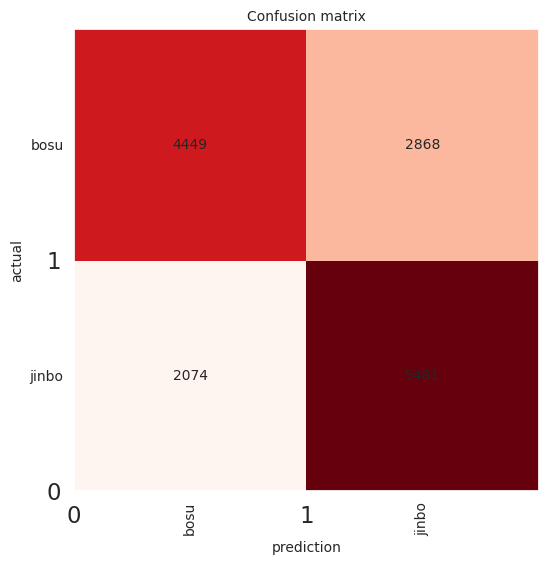

In [70]:
#@title 딥러닝 학습 평가하기

# 라벨 이름 설정 (예: 보수와 진보)
라벨링 = ['bosu', 'jinbo']  #@param

import time
import datetime

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    # 예측 값과 실제 라벨을 비교하여 정확도 계산
    pred_flat = np.argmax(preds, axis=1).flatten()  # 예측값 중 가장 큰 값의 인덱스 선택
    labels_flat = labels.flatten()  # 실제 라벨 값 평탄화
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 경과 시간 포맷 함수
def format_time(elapsed):
    # 경과된 시간을 hh:mm:ss 형식으로 변환
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 시작 시간 기록
t0 = time.time()

# 모델을 평가 모드로 전환 (학습을 중단하고 평가)
model.eval()

# 추적을 위한 변수 초기화
predictions, true_labels, predictionsfin = [], [], []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 테스트 데이터로더에서 배치 단위로 데이터를 가져와 평가
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시 (100 배치마다 경과 시간 출력)
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치 데이터를 GPU로 이동
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 없이 모델 실행 (평가이므로)
    with torch.no_grad():
        # Forward 수행 (모델 예측)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로짓(logits) 값 구하기
    logits = outputs[0]

    # 예측 결과를 CPU로 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 예측 값과 실제 라벨 저장
    predictions.append(logits)
    true_labels.append(label_ids)

    # 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

# 최종 평가 정확도 출력
print("")
print("##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

# 상세 모델 평가 (정밀도, 재현율, F1 점수 계산)
from sklearn.metrics import classification_report

rounded_labels_set = []
rounded_predictions_set = []

# 각 배치에 대한 예측 및 라벨 처리
for i in range(len(true_labels)):
    # 예측값에서 최대값을 선택하여 라벨로 변환
    rounded_labels = np.argmax(predictions[i], axis=1).flatten()
    rounded_labels_set.extend(rounded_labels)

    # 실제 라벨 값을 저장
    rounded_predictions = true_labels[i].flatten()
    rounded_predictions_set.extend(rounded_predictions)

# 라벨별 분류 리포트 출력
labels = 라벨링
print("")
print(classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))
print("")

# 혼동 행렬 (Confusion Matrix) 계산 및 시각화
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

# 혼동 행렬을 시각화하는 함수 정의
def plot_confusion_matrix(ax, matrix, labels, title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)
    ax.tick_params(which='major', labelbottom='off', labelleft='off')
    ax.tick_params(which='minor', width=0)
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # 혼동 행렬의 각 셀에 숫자 추가
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)
    plt.show()

# 혼동 행렬 시각화
if __name__ == '__main__':
    matrix = cm
    labels = 라벨링

    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(ax, matrix, labels, fontsize=10)
